# Module: calibration

This module contains functions for calibration of 4DSTEM data, including calibrating pixel sizes, calibrating the rotational offset between the real and diffraction planes, correcting diffraction shifts, and correcting elliptical distortions.

### Correct diffraction shifts, no beam stop

This notebook demos measuring and correction shifts of the diffraction patterns due to the scanning of the beam in real space.  This notebook requires that the Bragg peaks and Bragg vector map have already been measured. We proceed as follows:

Measure diffraction shifts
1. Get an initial guess at the diffraction shifts
2. Find outliers in initial diffraction shift guesses
3. Ignoring outliers, fit a plane or parabola to the initial guess.

Correct diffraction shifts
1. Apply shifts to the Bragg peak positions

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import leastsq
import numpy.ma as ma

from py4DSTEM.file.readwrite import FileBrowser
from py4DSTEM.process.braggdiskdetection import get_bragg_vector_map
from py4DSTEM.process.calibration import get_diffraction_shifts, find_outlier_shifts, shift_braggpeaks
from py4DSTEM.process.fit import fit_2D

In [2]:
# Examine file contents

fp = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
browser = FileBrowser(fp)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    datacube                            DataCube            
   1    braggvectormap_shiftcorrected_ellipsecorrectedDiffractionSlice    
   2    braggvectormap_uncorrected          DiffractionSlice    
   3    probe                               DiffractionSlice    
   4    diffraction_shifts                  RealSlice           
   5    strain_map                          RealSlice           
   6    uv_map                              RealSlice           
   7    lattice_vectors                     PointList           
   8    braggpeaks                          PointListArray      
   9    braggpeaks_shifted_ellipticalcorrectedPointListArray      


In [3]:
# Load data

dc = browser.get_dataobject('datacube')
braggpeaks = browser.get_dataobject('braggpeaks')
browser.close()

### Determine diffraction shifts

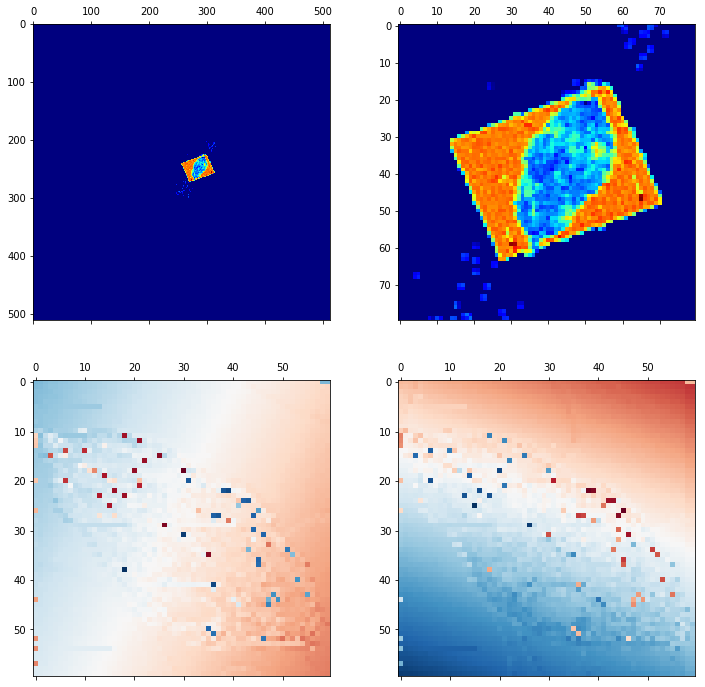

In [17]:
# Get diffraction shifts

findcenter = 'CoM'   # Must be 'CoM' or 'max'
rad = 40             # for display

xshifts, yshifts, braggvectormap_center = get_diffraction_shifts(braggpeaks,
                                                                dc.Q_Nx, dc.Q_Ny,
                                                                findcenter=findcenter)

# Show
x0,y0 = py4DSTEM.process.utils.get_CoM(braggvectormap_center)

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))
ax11.matshow(braggvectormap_center**0.25,cmap='jet')
ax12.matshow(braggvectormap_center[int(x0-rad):int(x0+rad),int(y0-rad):int(y0+rad)]**0.25,cmap='jet')
ax21.matshow(xshifts,cmap="RdBu")
ax22.matshow(yshifts,cmap="RdBu")
plt.show()

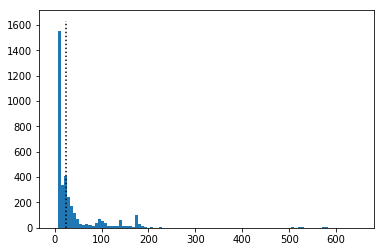

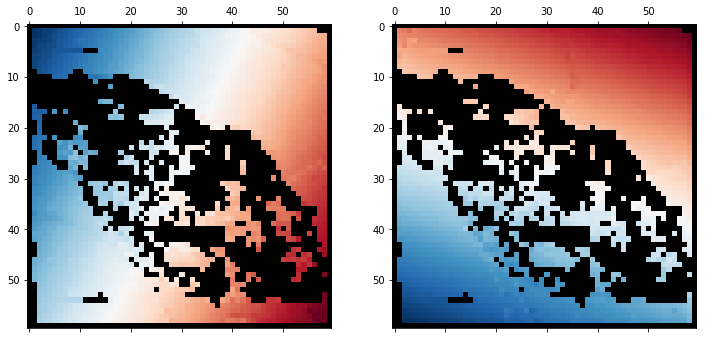

In [18]:
# Find outliers

n_sigma = 10
edge_boundary = 1
n_bins = 100

mask,n,bins,cutoff = find_outlier_shifts(xshifts,yshifts,n_sigma=n_sigma,edge_boundary=edge_boundary,n_bins=n_bins)

# Show
xshifts_masked = ma.masked_array(xshifts, mask)
yshifts_masked = ma.masked_array(yshifts, mask)
mask_display = ma.masked_array(mask, mask==False)

fig,ax = plt.subplots()
ax.bar(bins[:-1]+(bins[1]-bins[0])/2., n, (bins[1]-bins[0]), align='center')
ax.vlines(cutoff,0,ax.get_ylim()[1],linestyle=':')
plt.show()

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(xshifts_masked,cmap="RdBu")
ax2.matshow(yshifts_masked,cmap="RdBu")
ax1.matshow(mask_display)
ax2.matshow(mask_display)
plt.show()

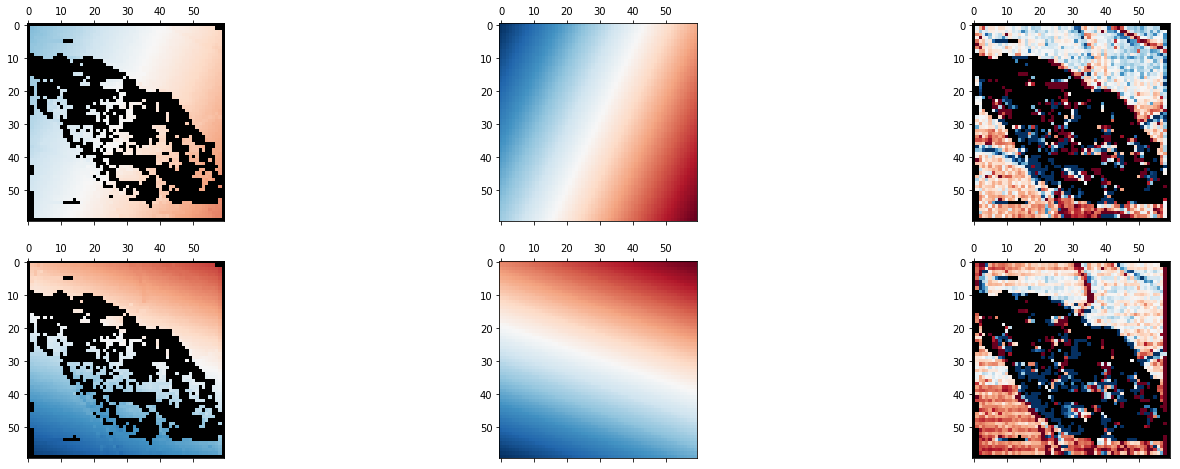

In [19]:
# Fit the diffraction shifts

fit_function = py4DSTEM.process.fit.plane        # Select fit type
#fit_function = py4DSTEM.process.fit.parabola

# Fit
xshifts_fit = np.zeros_like(xshifts)
yshifts_fit = np.zeros_like(yshifts)
popt_x, pcov_x, xshifts_fit = fit_2D(fit_function, xshifts, data_mask=mask==False)
popt_y, pcov_y, yshifts_fit = fit_2D(fit_function, yshifts, data_mask=mask==False)
residuals_x = xshifts-xshifts_fit
residuals_y = yshifts-yshifts_fit
residuals_x[mask] = 0
residuals_y[mask] = 0

# Show
fig,((ax11,ax12,ax13),(ax21,ax22,ax23))=plt.subplots(2,3,figsize=(24,8))
ax11.matshow(xshifts,cmap="RdBu")
ax21.matshow(yshifts,cmap="RdBu")
ax12.matshow(xshifts_fit,cmap="RdBu")
ax22.matshow(yshifts_fit,cmap="RdBu")
ax13.matshow(residuals_x,cmap="RdBu",vmin=np.median(residuals_x)-np.std(residuals_x),vmax=np.median(residuals_x)+np.std(residuals_x))
ax23.matshow(residuals_y,cmap="RdBu",vmin=np.median(residuals_y)-np.std(residuals_y),vmax=np.median(residuals_y)+np.std(residuals_y))
ax11.matshow(mask_display)
ax21.matshow(mask_display)
ax13.matshow(mask_display)
ax23.matshow(mask_display)
plt.show()

### Apply shifts, calculate shift-corrected Bragg vector map

In [20]:
# Apply shifts

shifted_braggpeaks = shift_braggpeaks(braggpeaks, xshifts_fit, yshifts_fit)

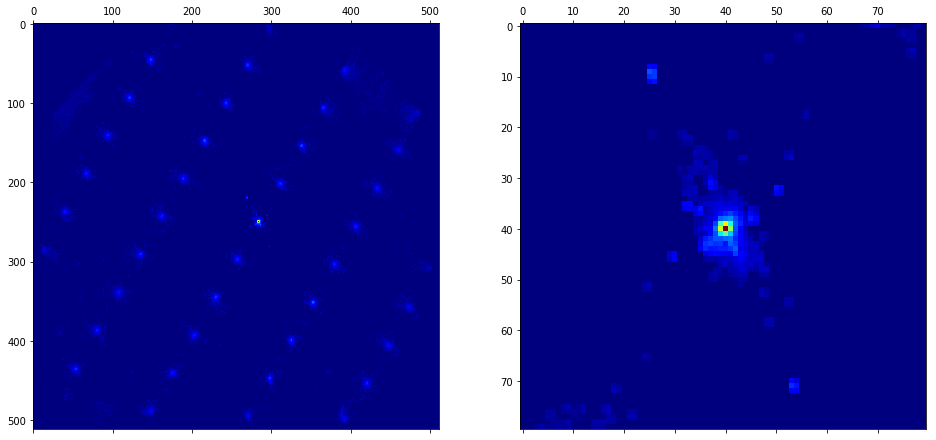

In [21]:
# Re-calculate Bragg vector map and show

braggvectormap = get_bragg_vector_map(shifted_braggpeaks,dc.Q_Nx,dc.Q_Ny)

# Show
x0,y0=np.unravel_index(np.argmax(gaussian_filter(braggvectormap,2)),(dc.Q_Nx,dc.Q_Ny))
x0,y0=int(x0),int(y0)
rad=40

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
ax1.matshow(braggvectormap**0.25,cmap='jet')
ax2.matshow(braggvectormap[x0-rad:x0+rad,y0-rad:y0+rad]**0.25,cmap='jet')
plt.show()